## Image Segmentation

### Setup

In [1]:
import random
from PIL import Image
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from tqdm import tqdm
import torch.optim as optim

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Downloading data

In [ ]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

--2024-02-16 16:35:29--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz [following]
--2024-02-16 16:35:29--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz [following]
--2024-02-16 16:35:29--  https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 301 Moved Perman

In [ ]:
input_dir = "images/"
target_dir = "annotations/trimaps/"

### Dataset

In [5]:
class SegmentDataset(Dataset):
  def __init__(self, image_dir, target_dir, image_size=(200,200), target_size=(200, 200),
               random_state=1337, train=True, transform=None):

    all_images_path = sorted(glob(image_dir + "/*.jpg"))
    all_targets_path = sorted(glob(target_dir + "/*.png"))


    random.Random(random_state).shuffle(all_images_path)
    random.Random(random_state).shuffle(all_targets_path)

    self.transform = transform
    self.image_size = image_size
    self.target_size = target_size

    num_val_samples = 1000
    if train:
      self.images_path = all_images_path[num_val_samples:]
      self.targets_path = all_targets_path[num_val_samples:]
    else:
      self.images_path = all_images_path[:num_val_samples]
      self.targets_path = all_targets_path[:num_val_samples]

  def __len__(self):
    return len(self.images_path)

  def image_read(self, path, size):
    im = Image.open(path).convert("RGB")
    im = im.resize(size)
    return np.array(im)

  def __getitem__(self, idx):
    image_path = self.images_path[idx]
    target_path = self.targets_path[idx]
    image = self.image_read(image_path, self.image_size)
    target = self.image_read(target_path, self.target_size)[:,:,0]
    if self.transform:
      image = self.transform(image)
    else:
      image = transforms.ToTensor()(image)
    target = torch.from_numpy(target.astype("uint8")) - 1
    return image.float(), target.long()

### Train

In [6]:
class Train:
    def __init__(self, model, device, criterion, optimizer, input_dir, target_dir, image_size, target_size, batch_size, normal_init) -> None:
        self.model = model.to(device)
        self.device = device
        self.criterion = criterion
        self.optimizer = optimizer
        self.image_size = image_size
        self.target_size = target_size
        self.batch_size = batch_size

        self.creat_dataset(input_dir, target_dir)
        self.creat_dataloader()

        if normal_init:
            model.apply(self.initialize_weight)

    def creat_dataset(self, input_dir, target_dir):
        self.train_dataset = SegmentDataset(
            input_dir, target_dir, self.image_size, self.target_size, train=True)
        self.val_dataset = SegmentDataset(
            input_dir, target_dir, self.image_size, self.target_size, train=False)

    def creat_dataloader(self, seed=42):
        torch.manual_seed(seed)
        self.train_dl = DataLoader(
            self.train_dataset, self.batch_size, shuffle=True)
        self.val_dl = DataLoader(self.val_dataset, self.batch_size)

    def initialize_weight(self, m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight)
            nn.init.zeros_(m.bias)

    def train(self, num_epochs):
        self.best_accuracy = 0.0
        self.patience_counter = 0

        train_losses = []
        train_accuracies = []
        test_losses = []
        test_accuracies = []

        for epoch in range(num_epochs):
            train_loss, train_accuracy = self.train_epoch()
            train_losses.append(train_loss)
            train_accuracies.append(train_accuracy)

            test_loss, test_accuracy = self.validate_epoch()
            test_losses.append(test_loss)
            test_accuracies.append(test_accuracy)

            print(f"Epoch: {epoch + 1}/{num_epochs} | Train loss: {train_loss:.4f} | Train Acc: {train_accuracy:.4f} | Test loss: {test_loss:.4f} | Test Acc: {test_accuracy:.4f}")

            if self.early_stopping(test_accuracy):
                print(
                    f"Early stopping at epoch {epoch}, best accuracy {self.best_accuracy}")
                break

        return train_losses, train_accuracies, test_losses, test_accuracies

    def train_epoch(self):
        self.model.train()
        train_loss = 0.0
        train_correct = 0

        for images, labels in tqdm(self.train_dl):
            images = images.to(device=device)
            labels = labels.to(device=device)

            output = self.model(images)
            loss = self.criterion(output, labels)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            train_loss += loss.item()

            predicted = torch.argmax(output.data, 1)
            train_correct += ((predicted == labels).sum().item()) / \
                (self.batch_size*self.target_size[0]*self.target_size[1])

        train_loss /= len(self.train_dl)
        train_accuracy = train_correct / len(self.train_dl)
        return train_loss, train_accuracy

    @torch.no_grad()
    def validate_epoch(self):
        self.model.eval()
        test_loss = 0
        test_correct = 0

        for images, labels in self.val_dl:
            images = images.to(device=device)
            labels = labels.to(device=device)

            output = self.model(images)
            loss = self.criterion(output, labels)

            test_loss += loss.item()

            predicted = torch.argmax(output.data, 1)
            test_correct += ((predicted == labels).sum().item()) / \
                (self.batch_size*self.target_size[0]*self.target_size[1])

        test_loss /= len(self.val_dl)
        test_accuracy = test_correct / len(self.val_dl)
        return test_loss, test_accuracy

    def early_stopping(self, test_accuracy, patience=5):
        if test_accuracy > self.best_accuracy:
            self.best_accuracy = test_accuracy
            self.patience_counter = 0
            torch.save(self.model.state_dict(), "best_model.pth")
        else:
            self.patience_counter += 1

        if self.patience_counter > patience:
            return True

        return False

### Chollet Architecture

In [7]:
class EncodeBlock(nn.Module):
      def __init__(self, in_channels: int, out_channels: int, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        self.layers = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU())


      def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layers(x)

In [8]:
class DecodeBlock(nn.Module):
      def __init__(self, in_channels: int, out_channels: int, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        self.layers = nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(out_channels,  out_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.ReLU())


      def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layers(x)

In [9]:
class CholletModel(nn.Module):
    def __init__(self, in_channels: int, num_classes: int,*args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.layers = nn.ModuleList()

        channels = [in_channels, 64, 128, 256]
        for index, size in enumerate(channels[:-1]):
          self.layers.append(EncodeBlock(in_channels=size, out_channels=channels[index+1]))

        transpose_channels = [256, 256, 128, 64]
        for index, size in enumerate(transpose_channels[:-1]):
          self.layers.append(DecodeBlock(in_channels=size, out_channels=transpose_channels[index+1]))

        self.layers.append(nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, padding=1))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for layer in self.layers:
            x = layer(x)
        return x

In [10]:
image_size = target_size = (200, 200)
learning_rate = 1e-3
batch_size = 64

chollet_model = CholletModel(in_channels=3, num_classes=3).to(device=device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(chollet_model.parameters(), lr=learning_rate)

train_chollet_model = Train(chollet_model, device, criterion, optimizer, input_dir, target_dir, image_size, target_size, batch_size, normal_init=True)

In [11]:
summary(chollet_model, (3, 200, 200))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 100, 100]           1,792
              ReLU-2         [-1, 64, 100, 100]               0
            Conv2d-3         [-1, 64, 100, 100]          36,928
              ReLU-4         [-1, 64, 100, 100]               0
       EncodeBlock-5         [-1, 64, 100, 100]               0
            Conv2d-6          [-1, 128, 50, 50]          73,856
              ReLU-7          [-1, 128, 50, 50]               0
            Conv2d-8          [-1, 128, 50, 50]         147,584
              ReLU-9          [-1, 128, 50, 50]               0
      EncodeBlock-10          [-1, 128, 50, 50]               0
           Conv2d-11          [-1, 256, 25, 25]         295,168
             ReLU-12          [-1, 256, 25, 25]               0
           Conv2d-13          [-1, 256, 25, 25]         590,080
             ReLU-14          [-1, 256,

In [12]:
chollet_train_losses, chollet_train_accuracies, chollet_test_losses, chollet_test_accuracies = train_chollet_model.train(num_epochs=10)

100%|██████████| 100/100 [01:53<00:00,  1.14s/it]


Epoch: 1/10 | Train loss: 7.7412 | Train Acc: 0.5763 | Test loss: 0.9267 | Test Acc: 0.5775


100%|██████████| 100/100 [01:56<00:00,  1.16s/it]


Epoch: 2/10 | Train loss: 0.9613 | Train Acc: 0.5866 | Test loss: 0.9253 | Test Acc: 0.5775


100%|██████████| 100/100 [01:56<00:00,  1.16s/it]


Epoch: 3/10 | Train loss: 0.8984 | Train Acc: 0.5864 | Test loss: 0.8935 | Test Acc: 0.5775


100%|██████████| 100/100 [01:55<00:00,  1.16s/it]


Epoch: 4/10 | Train loss: 0.8627 | Train Acc: 0.5869 | Test loss: 0.8246 | Test Acc: 0.6078


100%|██████████| 100/100 [01:55<00:00,  1.16s/it]


Epoch: 5/10 | Train loss: 0.8096 | Train Acc: 0.6338 | Test loss: 0.8011 | Test Acc: 0.6107


100%|██████████| 100/100 [01:55<00:00,  1.16s/it]


Epoch: 6/10 | Train loss: 0.7735 | Train Acc: 0.6753 | Test loss: 0.7221 | Test Acc: 0.6859


100%|██████████| 100/100 [01:55<00:00,  1.16s/it]


Epoch: 7/10 | Train loss: 0.8218 | Train Acc: 0.6465 | Test loss: 0.7702 | Test Acc: 0.5935


100%|██████████| 100/100 [01:55<00:00,  1.16s/it]


Epoch: 8/10 | Train loss: 0.7565 | Train Acc: 0.6901 | Test loss: 0.7171 | Test Acc: 0.6872


100%|██████████| 100/100 [01:55<00:00,  1.16s/it]


Epoch: 9/10 | Train loss: 0.7192 | Train Acc: 0.7044 | Test loss: 0.6814 | Test Acc: 0.6978


100%|██████████| 100/100 [01:56<00:00,  1.16s/it]


Epoch: 10/10 | Train loss: 0.6999 | Train Acc: 0.7121 | Test loss: 0.7295 | Test Acc: 0.6936


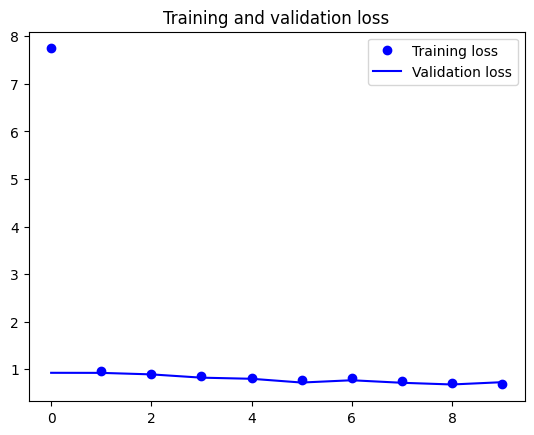

In [13]:
plt.figure()
plt.plot(chollet_train_losses, "bo", label="Training loss")
plt.plot(chollet_test_losses, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

### U-Net Architecture

In [14]:
class UNetBlock(nn.Module):
      def __init__(self, in_channels: int, out_channels: int, contracting_layer: bool=False, expansive_layer: bool=False, middle_channels=None, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        if not middle_channels:
          middle_channels = out_channels

        self.layers = nn.ModuleList([
        nn.Conv2d(in_channels, middle_channels, kernel_size=3),
        nn.ReLU(),
        nn.Conv2d(middle_channels, middle_channels, kernel_size=3),
        nn.ReLU()])

        if contracting_layer:
          self.layers.append(nn.MaxPool2d(kernel_size=2))
        elif expansive_layer:
          self.layers.append(nn.ConvTranspose2d(middle_channels, out_channels, kernel_size=2, stride=2))


      def forward(self, x: torch.Tensor) -> torch.Tensor:
        for layer in self.layers:
          x = layer(x)
        return x


In [16]:
class UNetModel(nn.Module):
    def __init__(self, in_channels: int, num_classes: int,*args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        self.contracting_layer1 = UNetBlock(in_channels, out_channels=64, contracting_layer=True)
        self.contracting_layer2 = UNetBlock(in_channels=64, out_channels=128, contracting_layer=True)
        self.contracting_layer3 = UNetBlock(in_channels=128, out_channels=256, contracting_layer=True)
        self.contracting_layer4 = UNetBlock(in_channels=256, out_channels=512, contracting_layer=True)

        self.expansive_layer1 = UNetBlock(in_channels=512, middle_channels=1024, out_channels=512, expansive_layer=True)
        self.expansive_layer2 = UNetBlock(in_channels=1024, middle_channels=512, out_channels=256, expansive_layer=True)
        self.expansive_layer3 = UNetBlock(in_channels=512, middle_channels=256, out_channels=128, expansive_layer=True)
        self.expansive_layer4 = UNetBlock(in_channels=256, middle_channels=128, out_channels=64, expansive_layer=True)

        self.output_layer = nn.Sequential(
        UNetBlock(in_channels=128, out_channels=64),
        nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1))


    def forward(self, input: torch.Tensor) -> torch.Tensor:
        cl1 = self.contracting_layer1(input)
        cl2 = self.contracting_layer2(cl1)
        cl3 = self.contracting_layer3(cl2)
        cl4 = self.contracting_layer4(cl3)

        ex1 = self.expansive_layer1(cl4)

        temp = torch.concat((transforms.functional.center_crop(cl4, ex1.shape[-1]), ex1), dim=1)
        ex2 = self.expansive_layer2(temp)

        temp = torch.concat((transforms.functional.center_crop(cl3, ex2.shape[-1]), ex2), dim=1)
        ex3 = self.expansive_layer3(temp)

        temp = torch.concat((transforms.functional.center_crop(cl2, ex3.shape[-1]), ex3), dim=1)
        ex4 = self.expansive_layer4(temp)

        temp = torch.concat((transforms.functional.center_crop(cl1, ex4.shape[-1]), ex4), dim=1)
        output = self.output_layer(temp)

        return output

In [19]:
image_size = (400, 400)
target_size = (212, 212)
learning_rate = 1e-3
batch_size = 8

unet_model = UNetModel(in_channels=3, num_classes=3).to(device=device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(unet_model.parameters(), lr=learning_rate)

train_unet_model = Train(unet_model, device, criterion, optimizer, input_dir, target_dir, image_size, target_size, batch_size, normal_init=True)

In [20]:
summary(unet_model, (3, 400, 400))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 398, 398]           1,792
              ReLU-2         [-1, 64, 398, 398]               0
            Conv2d-3         [-1, 64, 396, 396]          36,928
              ReLU-4         [-1, 64, 396, 396]               0
         MaxPool2d-5         [-1, 64, 198, 198]               0
         UNetBlock-6         [-1, 64, 198, 198]               0
            Conv2d-7        [-1, 128, 196, 196]          73,856
              ReLU-8        [-1, 128, 196, 196]               0
            Conv2d-9        [-1, 128, 194, 194]         147,584
             ReLU-10        [-1, 128, 194, 194]               0
        MaxPool2d-11          [-1, 128, 97, 97]               0
        UNetBlock-12          [-1, 128, 97, 97]               0
           Conv2d-13          [-1, 256, 95, 95]         295,168
             ReLU-14          [-1, 256,

In [22]:
unet_train_losses, unet_train_accuracies, unet_test_losses, unet_test_accuracies = train_unet_model.train(num_epochs=10)

100%|██████████| 799/799 [08:49<00:00,  1.51it/s]


Epoch: 1/10 | Train loss: 1.3107 | Train Acc: 0.6130 | Test loss: 0.7821 | Test Acc: 0.6930


100%|██████████| 799/799 [08:46<00:00,  1.52it/s]


Epoch: 2/10 | Train loss: 1.1279 | Train Acc: 0.6368 | Test loss: 0.7870 | Test Acc: 0.6947


100%|██████████| 799/799 [08:45<00:00,  1.52it/s]


Epoch: 3/10 | Train loss: 0.8274 | Train Acc: 0.6551 | Test loss: 0.8186 | Test Acc: 0.6130


100%|██████████| 799/799 [08:42<00:00,  1.53it/s]


Epoch: 4/10 | Train loss: 0.8105 | Train Acc: 0.6119 | Test loss: 0.7667 | Test Acc: 0.6468


100%|██████████| 799/799 [08:42<00:00,  1.53it/s]


Epoch: 5/10 | Train loss: 0.7557 | Train Acc: 0.6703 | Test loss: 0.7381 | Test Acc: 0.6843


100%|██████████| 799/799 [08:42<00:00,  1.53it/s]


Epoch: 6/10 | Train loss: 0.7259 | Train Acc: 0.6929 | Test loss: 0.6910 | Test Acc: 0.7102


100%|██████████| 799/799 [08:38<00:00,  1.54it/s]


Epoch: 7/10 | Train loss: 5001.7041 | Train Acc: 0.6401 | Test loss: 0.8117 | Test Acc: 0.6163


100%|██████████| 799/799 [08:39<00:00,  1.54it/s]


Epoch: 8/10 | Train loss: 0.8051 | Train Acc: 0.6302 | Test loss: 0.7957 | Test Acc: 0.6335


100%|██████████| 799/799 [08:38<00:00,  1.54it/s]


Epoch: 9/10 | Train loss: 0.7954 | Train Acc: 0.6400 | Test loss: 0.7888 | Test Acc: 0.6415


100%|██████████| 799/799 [08:37<00:00,  1.54it/s]


Epoch: 10/10 | Train loss: 0.7929 | Train Acc: 0.6432 | Test loss: 0.7790 | Test Acc: 0.6546


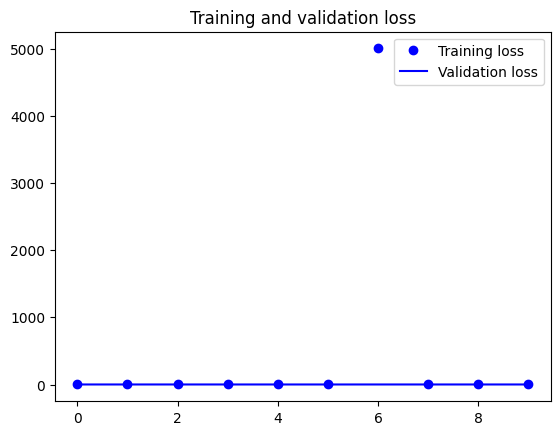

In [23]:
plt.figure()
plt.plot(unet_train_losses, "bo", label="Training loss")
plt.plot(unet_test_losses, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()